In [1]:
# import a custom plotting library
import some_plotters as plotter
import matplotlib.pyplot as plt

# import autograd functionality
import autograd.numpy as np

# import path to datasets
datapath = 'datasets/'

# this is needed to compensate for %matplotl+ib notebook's tendancy to blow up images when plotted inline
from matplotlib import rcParams
rcParams['figure.autolayout'] = True
%matplotlib notebook

# autoreload functi"on - so if anything behind the scenes is changeed those changes
# are reflected in the notebook without having to restart the kernel
%load_ext autoreload
%autoreload 2

#Other Imports
from autograd import value_and_grad 
from autograd.misc.flatten import flatten_func

#### <span style="color:#a50e3e;">Exercise 2: </span>  Imitation Learning on the two-tank problem 

In this exercise you will create a system model - using a small snippet of data for the two-tank problem outlined in the [course notes](https://github.com/jermwatt/control-notes).  This comes from a real life two-tanks experiment - the amount of water allowed into the top tank (per second) - the action sequence $a_t$ - is shown as the black curve in the bottom panel.  In the top panel the *upper* tank water level $s_{1,t}$ is shown in green, and the bottom tank level $s_{2,t}$ is shown in magenta.

In [2]:
# This code cell will not be shown in the HTML version of this notebook
# load series
data = np.loadtxt(datapath + 'cascaded_tanks_1.csv',delimiter = ',')
actions = data[0:1,1:]
states = data[1:,:]
# plot the test pair
#plotter.plot_3fer(actions,states[0],states[1],plot_type = 'continuous')

This system has two $s_{1,t}$ and $s_{2,t}$, hence the Imitator consists of an equation for each.  The upper tank level $s_{1,t}$ is dependent on its own history and - of course- the amount of water $a_t$ that is poured into it.  A simple linear model for this looks like

\begin{equation}
s_{1,t+1} = w_0 + w_1 s_{1,t} + w_2 a_t.
\end{equation}

Since we know that the upper tank drains into the lower one, the simplest sort of system model we can make for the lower tank level $s_{2,t}$ is that it is proportional to its prior value and that of the upper tank, as

\begin{equation}
s_{2,t+1} = w_3 + w_4s_{2,t} + w_5 s_{1,t}.
\end{equation}

Together - using the simplest model for this system we could think of - we have the following two system model equations

\begin{array}
\
s_{1,t+1} = w_0 + w_1 s_{1,t} + w_2 a_t \\
s_{2,t+1} = w_3 + w_4s_{2,t} + w_5 s_{1,t}.
\end{array}

Tune the parameters of this system model $w_0$ through $w_5$ via minimizing a Least Squares cost function so that your imitator learns to mimic the *second tank level* ($s_{2,t}$) - the magenta curve above.

Use the data shown above for training (i.e., you need not cut off a chunk of it for validation - use it all for training).  

Make sure to plot the fit your model provides on the training data.  You can see this exact system model fit to this exact dataset in the course notes - make sure your fit looks fairly similar.

Your result should look something like the one below - shown in dashed black.

<figure>
<p>
<img src= 'images/bottom_tank_approximate.png' width="150%" height="150%" alt=""/>
</p>
</figure>

In [3]:
#pull the gradient descent function from the helper functions notebook
def gradient_descent(g,w_init,alpha,max_its,verbose): 
    # flatten the input function
    g_flat, unflatten, w = flatten_func(g, w_init)
    
    # compute gradient of flattened input function
    # when evaluated this returns both the evaluation of the gradient and the original function
    grad = value_and_grad(g_flat)
    cost_eval,grad_eval = grad(w)
    grad_eval.shape = np.shape(w)

    # record history
    w_hist = [unflatten(w)]
    train_hist = [cost_eval]
        
    # gradient descent loop
    for k in range(max_its): 
        # take descent step with momentum
        w = w - alpha*grad_eval
        
        # plug in updated w into func and gradient
        cost_eval,grad_eval = grad(w)
        grad_eval.shape = np.shape(w)
                
        # store updates
        w_hist.append(unflatten(w))
        train_hist.append(cost_eval)

        # print update
        if verbose == True:
            print ('step ' + str(k+1) + ' complete, train cost = ' + str(np.round(train_hist[-1],4)[0]))

    # print update and return
    if verbose == True:
        print ('finished all ' + str(max_its) + ' steps')
    return w_hist,train_hist

In [4]:
# standard normalization function 
def standard_normalizer(x):
    # compute the mean and standard deviation of the input
    x_means = np.mean(x,axis = 1)[:,np.newaxis]
    x_stds = np.std(x,axis = 1)[:,np.newaxis]   

    # check to make sure thta x_stds > small threshold, for those not
    # divide by 1 instead of original standard deviation
    ind = np.argwhere(x_stds < 10**(-2))
    if len(ind) > 0:
        ind = [v[0] for v in ind]
        adjust = np.zeros((x_stds.shape))
        adjust[ind] = 1.0
        x_stds += adjust

    # create standard normalizer function
    normalizer = lambda data: (data - x_means)/x_stds

    # create inverse standard normalizer
    inverse_normalizer = lambda data: data*x_stds + x_means

    # return normalizer 
    return normalizer,inverse_normalizer

In [5]:
#Define the model as set above
def model(s,a,w):
    s1_t = w[0] + s[0]*w[1] + a*w[2]
    s2_t = w[3] + s[1]*w[4] + s[0]*w[5]
    return np.array([s1_t,s2_t])

def system_loop(s,a,w):
    s_pred = [s[1,0]]
    for i in range(a.shape[1]):
        #Grab current a-spair
        a_t = a[:,i]
        s_t = s[:,i]
        
        #Model it
        shat = model(s_t, a_t, w)
        
        #Store it
        s_pred.append(shat[1])
        
    # Convert to an array
    s_pred = np.array(s_pred)
    return s_pred[np.newaxis,:]

#Define the least squares cost function
def least_squares(s,a,w):
    #Total time
    T = len(s[0,:])
    #Compute the predictions
    pred = system_loop(s,a,w)
    #Compute least squares
    cost = np.sum((pred[:,1:] - s[1,1:])**2)
    return cost/T-1

In [6]:
#Relabel the data because of a typo earlier in the code and my lack of desire to refactor
states_train = states
actions_train = actions

In [7]:
#Normalize the data for training by first, grabbing the functions/inv functions and second, actually normalizing
#Grab state, action normalization/inv norm. functions
state_norm, state_inv_norm = standard_normalizer(states_train)
action_norm, action_inv_norm = standard_normalizer(actions_train)

#Normalize state-actions
actions_train_normalized = action_norm(actions_train)
states_train_normalized = state_norm(states_train)

In [23]:
#Gradient Descent Params 
w_init = np.random.randn(6,1)
alpha = 10**-2
max_its = 200
verbose = True

s = states_train_normalized
a = actions_train_normalized
w = w_init

#Make an instance of Least Squares with the data locked in
g = lambda w, a = actions_train_normalized, s = states_train_normalized: least_squares(s,a,w)

#Run gradient descent 
whx,thx = gradient_descent(g, w_init, alpha, max_its, verbose)

step 1 complete, train cost = 3.7921
step 2 complete, train cost = 3.4413
step 3 complete, train cost = 3.1161
step 4 complete, train cost = 2.8149
step 5 complete, train cost = 2.5357
step 6 complete, train cost = 2.277
step 7 complete, train cost = 2.0373
step 8 complete, train cost = 1.8152
step 9 complete, train cost = 1.6094
step 10 complete, train cost = 1.4187
step 11 complete, train cost = 1.242
step 12 complete, train cost = 1.0783
step 13 complete, train cost = 0.9266
step 14 complete, train cost = 0.786
step 15 complete, train cost = 0.6557
step 16 complete, train cost = 0.535
step 17 complete, train cost = 0.4231
step 18 complete, train cost = 0.3195
step 19 complete, train cost = 0.2234
step 20 complete, train cost = 0.1344
step 21 complete, train cost = 0.0519
step 22 complete, train cost = -0.0245
step 23 complete, train cost = -0.0953
step 24 complete, train cost = -0.161
step 25 complete, train cost = -0.2218
step 26 complete, train cost = -0.2781
step 27 complete, tra

In [24]:
#Find the best of the weights
ind = np.argmin(thx)
w_best = whx[ind]
gbest = thx[ind]
#Print the best cost and the best weights
print("--Best Cost--")
print(gbest)
print("--Best Weights--")
print(w_best)

--Best Cost--
[-0.99539809]
--Best Weights--
[[-0.1635899 ]
 [ 1.02523208]
 [ 0.58334271]
 [ 0.00171081]
 [ 0.80719519]
 [ 0.20125741]]


-- Mean of Squared Error --
0.0046019132413


/home/chris/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


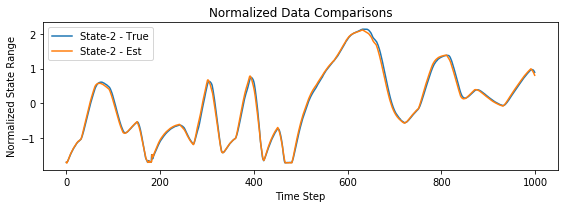

In [25]:
#Test the model with normalized data  - this is for testing 
arr = system_loop(s,a,w_best)
test = states_train_normalized[1]
#Error Comp
err = arr - test
print("-- Mean of Squared Error --")
print(np.mean(err**2)/len(err))
plt.figure(num=1,figsize = (8,3))
plt.title("Normalized Data Comparisons")
plt.xlabel("Time Step")
plt.ylabel("Normalized State Range")
plt.plot(test)
plt.plot(arr.T)
plt.legend(["State-2 - True", "State-2 - Est"])

/home/chris/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


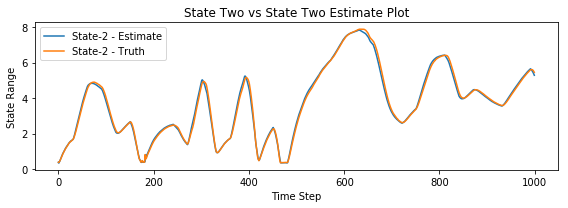

In [26]:
# ---- SOLUTION ---- 
#Normalize state-actions
states_normed = state_norm(states_train)
actions_normed = action_norm(actions_train)

#Loop through the state-actions
s2_unnormalized = system_loop(states_normed,actions_normed,w_best)
    
#Unnormalize the second state
state_est_unnormed_2 = state_inv_norm(s2_unnormalized)

#Since the unnorm function considers two vectors... we pull just the one that's NON ZERO
state_est_unnormed_2 = state_est_unnormed_2[1,:]

#Plot Labels and Setup
plt.figure(num=2,figsize = (8,3))
plt.title("State Two vs State Two Estimate Plot")
plt.xlabel("Time Step")
plt.ylabel("State Range")
#Plot the unnormalized state estimates
plt.plot(state_est_unnormed_2)

#Plot the input states
plt.plot(states[1,:].T)

#Legend and Display
plt.legend(["State-2 - Estimate", "State-2 - Truth"])
plt.show()

Since the estimate follows the data quite accurately (with a minor lag, it seems), it can be stated that the model is able to accurately track the second state and provide reasonable estimates. 